In [ ]:
  !pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 43.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics.classification import BinaryJaccardIndex
#
import PIL
from PIL import Image
#
from google.colab import drive

drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/Unet'
files = os.listdir(folder_path)
print(files)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['models', 'image']


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Datos


In [ ]:
train_fish = '/content/drive/MyDrive/Unet/image/480x640_train_fish'
#train_fish_fil = pass
train_mask = '/content/drive/MyDrive/Unet/image/480x640_train_mask_bin1'

test_fish = '/content/drive/MyDrive/Unet/image/480x640_test_fish'
#test_fish_fil = pass
test_mask = '/content/drive/MyDrive/Unet/image/480x640_test_mask_bin1'

predicted_mask = '/content/drive/MyDrive/Unet/image/predicted_masks_ordenadas'
#predicted_mask_wfill = pass
pdi_mask = '/content/drive/MyDrive/Unet/image/mascaras_pdi1'



In [ ]:
# creating our own Dataset
class Fish_Dataset(Dataset):
    def __init__(self, data, masks=None, img_transforms=None, mask_transforms=None):
        '''
        data - train data path
        masks - train masks path
        '''
        self.train_data = data
        self.train_masks = masks

        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

        self.images = sorted(os.listdir(self.train_data))
        self.masks = sorted(os.listdir(self.train_masks))

    def __len__(self):
        if self.train_masks is not None:
            assert len(self.images)==len(self.masks), 'not the same number of images and masks'
        return len(self.images)

    def __getitem__(self, idx):
        image_name = os.path.join(self.train_data, self.images[idx])
        img = Image.open(image_name)
        trans = T.ToTensor()
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img =trans(img)

        if self.train_masks is not None:
            mask_name = os.path.join(self.train_masks, self.masks[idx])
            mask = Image.open(mask_name)
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)

            mask_max = mask.max().item()
            mask /= mask_max
        else:
            return img

        return img, mask

In [ ]:
transform_data = T.Compose([
                T.Resize([640, 480]),
                T.ToTensor()] )

Instanciar Dataset


In [ ]:
full_dataset = Fish_Dataset(train_fish,
                           train_mask,
                           img_transforms=transform_data,
                           mask_transforms=transform_data)

Iniciar datos para métricas

In [ ]:
BATCH_SIZE = 16
batch_metric=1
TRAIN_SIZE = int(len(full_dataset)*0.8)
VAL_SIZE = len(full_dataset) - TRAIN_SIZE

In [ ]:
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])

In [ ]:
#print(len(train_dataset),len(val_dataset))

304 76


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
print(len(train_loader),len(val_loader))

19 5


# Comparacion de metricas

In [ ]:
#Cargar dataset para imagenes de PDI
#pdi_mask = carpeta de segmentaciones hechas con pdi
mask_pdi = Fish_Dataset(pdi_mask,
                        img_transforms=transform_data)

pdi_loader = DataLoader(mask_pdi, batch_size=batch_metric)



#Cargar dataset para imagenes de las etiquetadas manualmente
#test_mask = carpeta de segmentaciones hechas manuales
test_dataset = Fish_Dataset(test_mask,
                           img_transforms=transform_data)
test_mask_loader = DataLoader(test_dataset, batch_size=batch_metric)

#cargar Predicted hibrid

In [ ]:
#Cargar dataset para imagenes de las predicciones de UNET
#predicted_mask = carpeta de segmentaciones hechas con Unet
predicted_data = Fish_Dataset(predicted_mask,
                           img_transforms=transform_data)

predicted_loader = DataLoader(predicted_data, batch_size=batch_metric)

In [ ]:
#Conocer las dimensiones de los dataloader
metricas = next(iter(predicted_loader))
original_mask = next(iter(test_mask_loader))
num1 = next(iter(pdi_loader))
print(metricas.shape,original_mask.shape,num1.shape)

torch.Size([1, 1, 640, 480]) torch.Size([1, 1, 640, 480]) torch.Size([1, 1, 640, 480])


Comparación entre PDI y manuales

In [ ]:
def calculate_and_plot_iou(pdi_loader, test_dataset, num_batches=78):
    metric = BinaryJaccardIndex()
    ious = []

    for i, (pdi_batch, test_batch) in enumerate(zip(pdi_loader, test_dataset)):
        if i >= num_batches:
            break

        pdi_images = pdi_batch
        test_masks = test_batch

        # Asegurarse de que los tensores estén en el dispositivo correcto (CPU o GPU)
        pdi_images = pdi_images.to(metric.device)
        test_masks = test_masks.to(metric.device)

        # Calcular IoU
        iou = metric(pdi_images.squeeze(), test_masks.squeeze())
        ious.append(iou.item())

        print(f"IoU de la segmentación {i}: {iou.item()}")

    # Mostrar resultados generales
    average_iou = sum(ious) / len(ious)
    print(f"Promedio de IoU: {average_iou}")

    # Plotear el IoU
    fig, ax = plt.subplots()
    ax.plot(range(len(ious)), ious, label='IoU por imagen')
    plt.xlim(0, num_batches - 1)
    ax.set_xlabel('Imagen')
    ax.set_ylabel('IoU')
    ax.set_title('IoU por imagen')
    ax.legend()
    plt.show()

    return ious, average_iou

IoU de la segmentación 0: 0.880835771560669
IoU de la segmentación 1: 0.8620594143867493
IoU de la segmentación 2: 0.8944482803344727
IoU de la segmentación 3: 0.9140774607658386
IoU de la segmentación 4: 0.8456289172172546
IoU de la segmentación 5: 0.911264955997467
IoU de la segmentación 6: 0.9092762470245361
IoU de la segmentación 7: 0.6882814168930054
IoU de la segmentación 8: 0.7798076868057251
IoU de la segmentación 9: 0.929924488067627
IoU de la segmentación 10: 0.3124317228794098
IoU de la segmentación 11: 0.6752758622169495
IoU de la segmentación 12: 0.8814380764961243
IoU de la segmentación 13: 0.8509804010391235
IoU de la segmentación 14: 0.8370750546455383
IoU de la segmentación 15: 0.8170425891876221
IoU de la segmentación 16: 0.9008398056030273
IoU de la segmentación 17: 0.8784179091453552
IoU de la segmentación 18: 0.8230233788490295
IoU de la segmentación 19: 0.9122953414916992
IoU de la segmentación 20: 0.8753888010978699
IoU de la segmentación 21: 0.9338462948799133
I

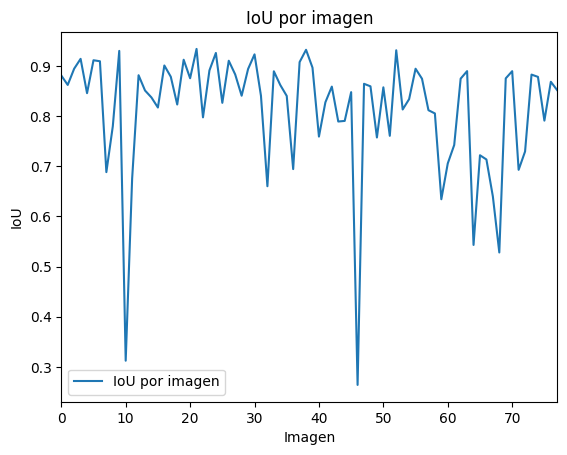

([0.880835771560669,
  0.8620594143867493,
  0.8944482803344727,
  0.9140774607658386,
  0.8456289172172546,
  0.911264955997467,
  0.9092762470245361,
  0.6882814168930054,
  0.7798076868057251,
  0.929924488067627,
  0.3124317228794098,
  0.6752758622169495,
  0.8814380764961243,
  0.8509804010391235,
  0.8370750546455383,
  0.8170425891876221,
  0.9008398056030273,
  0.8784179091453552,
  0.8230233788490295,
  0.9122953414916992,
  0.8753888010978699,
  0.9338462948799133,
  0.7974821329116821,
  0.8910374641418457,
  0.9258114099502563,
  0.8264045119285583,
  0.9102980494499207,
  0.8829501271247864,
  0.8405722379684448,
  0.8938494920730591,
  0.9229846596717834,
  0.8403846025466919,
  0.6601769924163818,
  0.8892617225646973,
  0.8618700504302979,
  0.8401719331741333,
  0.6943396329879761,
  0.907608687877655,
  0.9321163892745972,
  0.896518349647522,
  0.7591463327407837,
  0.8274445533752441,
  0.858741283416748,
  0.7891525626182556,
  0.7903661131858826,
  0.847682118415

In [ ]:
calculate_and_plot_iou(pdi_loader, test_mask_loader)

IoU de la segmentación 0: 0.880835771560669
IoU de la segmentación 1: 0.8620594143867493
IoU de la segmentación 2: 0.8944482803344727
IoU de la segmentación 3: 0.9140774607658386
IoU de la segmentación 4: 0.8456289172172546
IoU de la segmentación 5: 0.911264955997467
IoU de la segmentación 6: 0.9092762470245361
IoU de la segmentación 7: 0.6882814168930054
IoU de la segmentación 8: 0.7798076868057251
IoU de la segmentación 9: 0.929924488067627
IoU de la segmentación 10: 0.3124317228794098
IoU de la segmentación 11: 0.6752758622169495
IoU de la segmentación 12: 0.8814380764961243
IoU de la segmentación 13: 0.8509804010391235
IoU de la segmentación 14: 0.8370750546455383
IoU de la segmentación 15: 0.8170425891876221
IoU de la segmentación 16: 0.9008398056030273
IoU de la segmentación 17: 0.8784179091453552
IoU de la segmentación 18: 0.8230233788490295
IoU de la segmentación 19: 0.9122953414916992
IoU de la segmentación 20: 0.8753888010978699
IoU de la segmentación 21: 0.9338462948799133
I

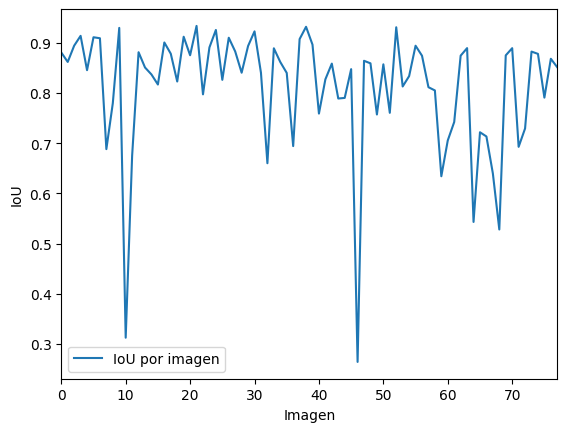

In [ ]:
metric = BinaryJaccardIndex()

# Listas para almacenar los resultados
ious = []

# Iterar sobre los primeros 78 lotes del DataLoader
for i, (pdi_batch, test_batch) in enumerate(zip(pdi_loader, test_dataset)):
    pdi_images = pdi_batch
    test_masks = test_batch

    # Calcular IoU
    iou = metric(pdi_images.squeeze(), test_masks.squeeze())
    ious.append(iou.item())  # Guardar el valor de IoU como un número

    print(f"IoU de la segmentación {i}: {iou.item()}")

# Mostrar resultados generales
print(f"Promedio de IoU: {sum(ious)/len(ious)}")

# Plotear el IoU
fig, ax = plt.subplots()
ax.plot(range(len(ious)), ious, label='IoU por imagen')
plt.xlim(0,77)
ax.set_xlabel('Imagen')
ax.set_ylabel('IoU')
ax.legend()
plt.show()
#fig.savefig('/content/drive/MyDrive/Unet/Graficos/iou_plot.svg')

Comparacion entre predicciones y manuales

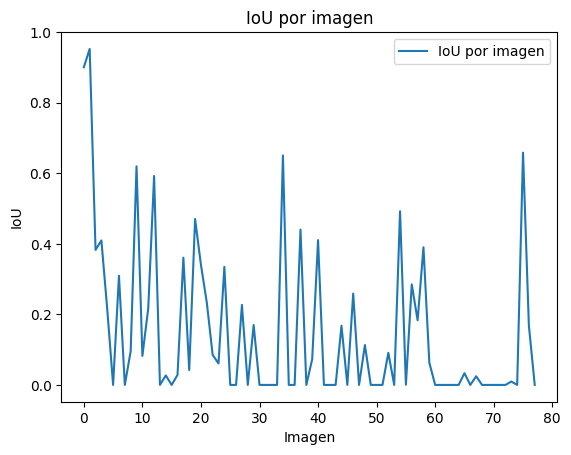

In [ ]:
metric1 = BinaryJaccardIndex()

# Listas para almacenar los resultados
ious_mask = []

# Iterar sobre los primeros 78 lotes del DataLoader
for j, (predicted_batch, test_batch) in enumerate(zip(predicted_loader, test_dataset)):
    predicted_images = predicted_batch[0]
    test_masks = test_batch[0]

    # Calcular IoU
    iou_mask = metric1(predicted_images.squeeze(), test_masks.squeeze())
    ious_mask.append(iou_mask.item())  # Guardar el valor de IoU como un número

    #print(f"IoU de la segmentación {i}: {iou.item()}")

# Mostrar resultados generales
#print(f"Promedio de IoU: {sum(ious)/len(ious)}")

# Plotear el IoU
fig, ax = plt.subplots()
ax.plot(range(len(ious_mask)), ious_mask, label='IoU por imagen')
ax.set_xlabel('Imagen')
ax.set_ylabel('IoU')
ax.set_title('IoU por imagen')
ax.legend()
plt.show()

ValueError: Unexpected keyword arguments: `reduce`

In [ ]:
#for i, (x, y) in enumerate(train_loader):
    #print(i, x.shape, y.shape)
    #if i==9: break

# Metricas

In [ ]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)

        return cost/len(loader), float(correct)/total, dice, iou

In [ ]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long).squeeze(1)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)

        preds = torch.argmax(scores, dim=1)
        acc_ = (preds == y).sum()/torch.numel(scores)
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr

    return log_lrs, losses, accuracies

In [ ]:
def train(model, optimiser, scheduler = None, epochs = 100, store_every = 16):
    model = model.to(device=device)
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

            if scheduler:
                scheduler.step()

            train_predictions = torch.argmax(scores, dim=1)
            train_correct_num += (train_predictions == y).sum()
            train_total += torch.numel(train_predictions)
            train_cost_acum += cost.item()

            if mb%store_every == 0:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb
                print(f'epoch: {epoch}, mb: {mb}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                      f'dice: {dice:.4f}, iou: {iou:.4f}')

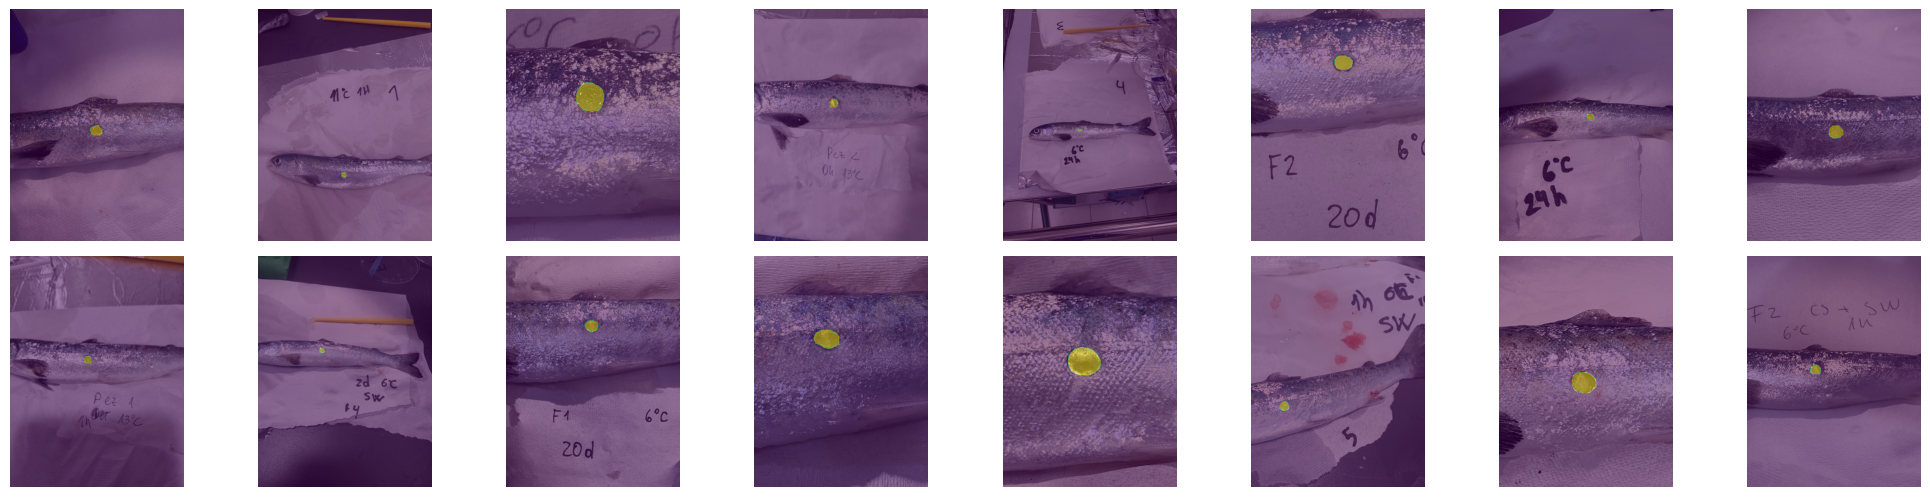

In [ ]:
imgs, masks = next(iter(train_loader))
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4, 8, i+1)
        img=imgs[i,...].permute(1,2,0).numpy()
        mask = masks[i, ...].permute(1,2,0).numpy()
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)

        plt.axis('Off')
    plt.tight_layout()
    plt.show()
plot_mini_batch(imgs, masks)

#Modelo

In [ ]:
class Conv_3_k(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        return self.conv1(x)

In [ ]:
class Double_Conv(nn.Module):
    '''
    Double convolution block for U-Net
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
                           Conv_3_k(channels_in, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),

                           Conv_3_k(channels_out, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
                            )
    def forward(self, x):
        return self.double_conv(x)

class Down_Conv(nn.Module):
    '''
    Down convolution part
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
                        nn.MaxPool2d(2,2),
                        Double_Conv(channels_in, channels_out)
                        )
    def forward(self, x):
        return self.encoder(x)

class Up_Conv(nn.Module):
    '''
    Up convolution part
    '''
    def __init__(self,channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bicubic'),
                        nn.Conv2d(channels_in, channels_in//2, kernel_size=1, stride=1)
                        )
        self.decoder = Double_Conv(channels_in, channels_out)

    def forward(self, x1, x2):
        '''
        x1 - upsampled volume
        x2 - volume from down sample to concatenate
        '''
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1],dim=1)
        return self.decoder(x)

class UNET(nn.Module):
    '''
    UNET model
    '''
    def __init__(self, channels_in, channels, num_classes):
        super().__init__()
        self.first_conv = Double_Conv(channels_in, channels) #64, 224, 224
        self.down_conv1 = Down_Conv(channels, 2*channels) # 128, 112, 112
        self.down_conv2 = Down_Conv(2*channels, 4*channels) # 256, 56, 56
        self.down_conv3 = Down_Conv(4*channels, 8*channels) # 512, 28, 28

        self.middle_conv = Down_Conv(8*channels, 16*channels) # 1024, 14, 14

        self.up_conv1 = Up_Conv(16*channels, 8*channels)
        self.up_conv2 = Up_Conv(8*channels, 4*channels)
        self.up_conv3 = Up_Conv(4*channels, 2*channels)
        self.up_conv4 = Up_Conv(2*channels, channels)

        self.last_conv = nn.Conv2d(channels, num_classes, kernel_size=1, stride=1)

    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)

        x5 = self.middle_conv(x4)

        u1 = self.up_conv1(x5, x4)
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)


        return self.last_conv(u4)

In [ ]:
'''def test():
    x = torch.randn((16, 3, 640, 480))
    modelunet = UNET(3, 64, 2)
    return modelunet(x)'''

'def test():\n    x = torch.randn((16, 3, 640, 480))\n    modelunet = UNET(3, 64, 2)\n    return modelunet(x)'

In [ ]:
'''preds = test()'''

'preds = test()'

In [ ]:
'''print(preds.shape)'''

'print(preds.shape)'

#Learning rate

In [ ]:
# define the model and look for learning rate
torch.manual_seed(42)
model = UNET(3, 64, 2)
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)

lg_lr, losses, accuracies = find_lr(model, optimiser_unet, start_val=1e-6, end_val=10)

cost:0.5695, lr: 0.0000, acc: 0.3774
cost:0.5711, lr: 0.0000, acc: 0.3737
cost:0.5695, lr: 0.0000, acc: 0.3811
cost:0.5713, lr: 0.0000, acc: 0.3735
cost:0.5722, lr: 0.0000, acc: 0.3717
cost:0.5709, lr: 0.0001, acc: 0.3682
cost:0.5680, lr: 0.0002, acc: 0.3780
cost:0.5599, lr: 0.0005, acc: 0.3854
cost:0.5483, lr: 0.0013, acc: 0.4103
cost:0.5044, lr: 0.0032, acc: 0.4555
cost:0.4198, lr: 0.0077, acc: 0.4716
cost:0.2725, lr: 0.0190, acc: 0.4914
cost:0.0991, lr: 0.0464, acc: 0.4962
cost:0.0392, lr: 0.1136, acc: 0.4977
cost:0.1196, lr: 0.2783, acc: 0.4968
cost:0.1568, lr: 0.6813, acc: 0.4966
cost:0.2110, lr: 1.6681, acc: 0.4957
cost:0.2487, lr: 4.0842, acc: 0.4967
cost:1.2665, lr: 10.0000, acc: 0.4977


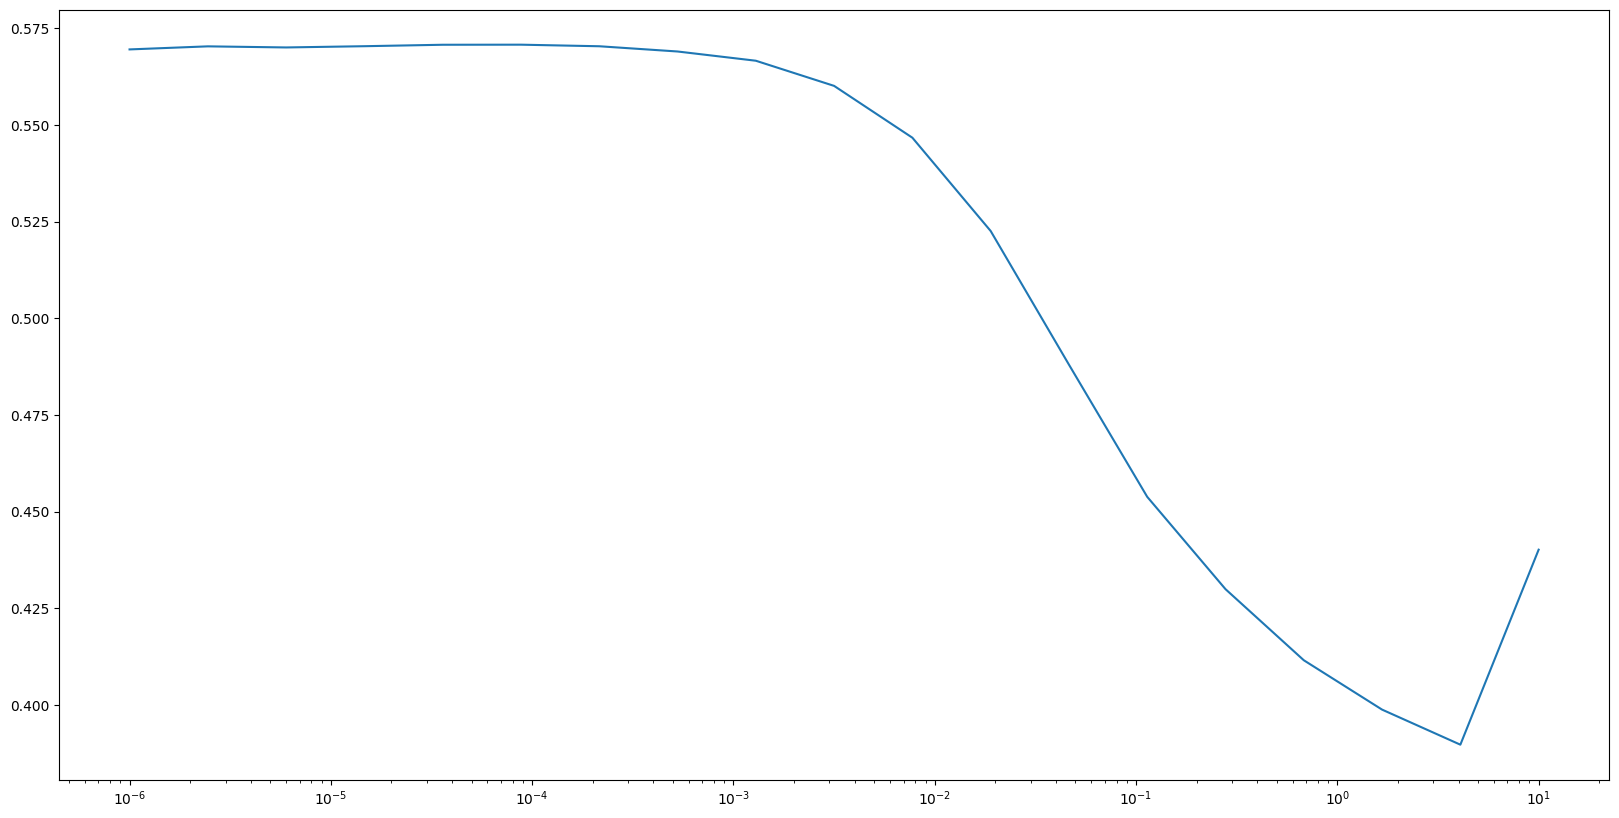

In [ ]:
# plot loss vs learning rate
f1, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
plt.show()

In [ ]:
# define the model and train with scheduler
torch.manual_seed(42)
model = UNET(3, 64, 2)
epochs = 100
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet,
                                                max_lr = 1,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

#Entrenamiento

In [ ]:
train(model, optimiser_unet, scheduler, epochs)

epoch: 0, mb: 16, train cost: 0.0811, val cost: 0.0193,train acc: 0.9785, val acc: 0.9927,dice: 0.0000, iou: 0.0000
epoch: 1, mb: 16, train cost: 0.0179, val cost: 0.0249,train acc: 0.9941, val acc: 0.9927,dice: 0.0000, iou: 0.0000
epoch: 2, mb: 16, train cost: 0.0163, val cost: 0.0208,train acc: 0.9945, val acc: 0.9927,dice: 0.0000, iou: 0.0000
epoch: 3, mb: 16, train cost: 0.0160, val cost: 0.0194,train acc: 0.9942, val acc: 0.9927,dice: 0.0000, iou: 0.0000
epoch: 4, mb: 16, train cost: 0.0135, val cost: 0.0170,train acc: 0.9945, val acc: 0.9927,dice: 0.0000, iou: 0.0000
epoch: 5, mb: 16, train cost: 0.0125, val cost: 0.0148,train acc: 0.9944, val acc: 0.9927,dice: 0.0000, iou: 0.0000
epoch: 6, mb: 16, train cost: 0.0109, val cost: 0.0127,train acc: 0.9940, val acc: 0.9927,dice: 0.0000, iou: 0.0000
epoch: 7, mb: 16, train cost: 0.0082, val cost: 0.0115,train acc: 0.9945, val acc: 0.9927,dice: 0.0000, iou: 0.0000
epoch: 8, mb: 16, train cost: 0.0074, val cost: 0.0086,train acc: 0.9942

In [ ]:
# Guardar el modelo entrenado y el optimizador
torch.save({
    'model_state_dict': model.state_dict(),
    'optimiser_state_dict': optimiser_unet.state_dict(),
    'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
    'epoch': epochs
}, '/content/drive/MyDrive/Unet/models/unet_model_raw.pth')


In [ ]:
# Cargar el modelo guardado
checkpoint = torch.load('/content/drive/MyDrive/Unet/models/unet_model_raw.pth')

# Crear una nueva instancia del modelo y del optimizador
model = UNET(3, 64, 2)
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)

# Cargar los pesos guardados en el modelo
model.load_state_dict(checkpoint['model_state_dict'])

# Cargar el estado del optimizador
optimiser_unet.load_state_dict(checkpoint['optimiser_state_dict'])

# Cargar el scheduler si existe
if checkpoint['scheduler_state_dict']:
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# Establecer el modelo en modo evaluación si solo necesitas inferencia
model.eval()  # o model.train() si planeas continuar entrenando

# Retomar el número de épocas (opcional)
start_epoch = checkpoint['epoch']


Como esta quedando el modelo

In [ ]:
'''imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))'''

#Prueba del Modelo

In [ ]:
test_set = Fish_Dataset(test_fish, img_transforms=transform_data)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

torch.Size([16, 640, 480])


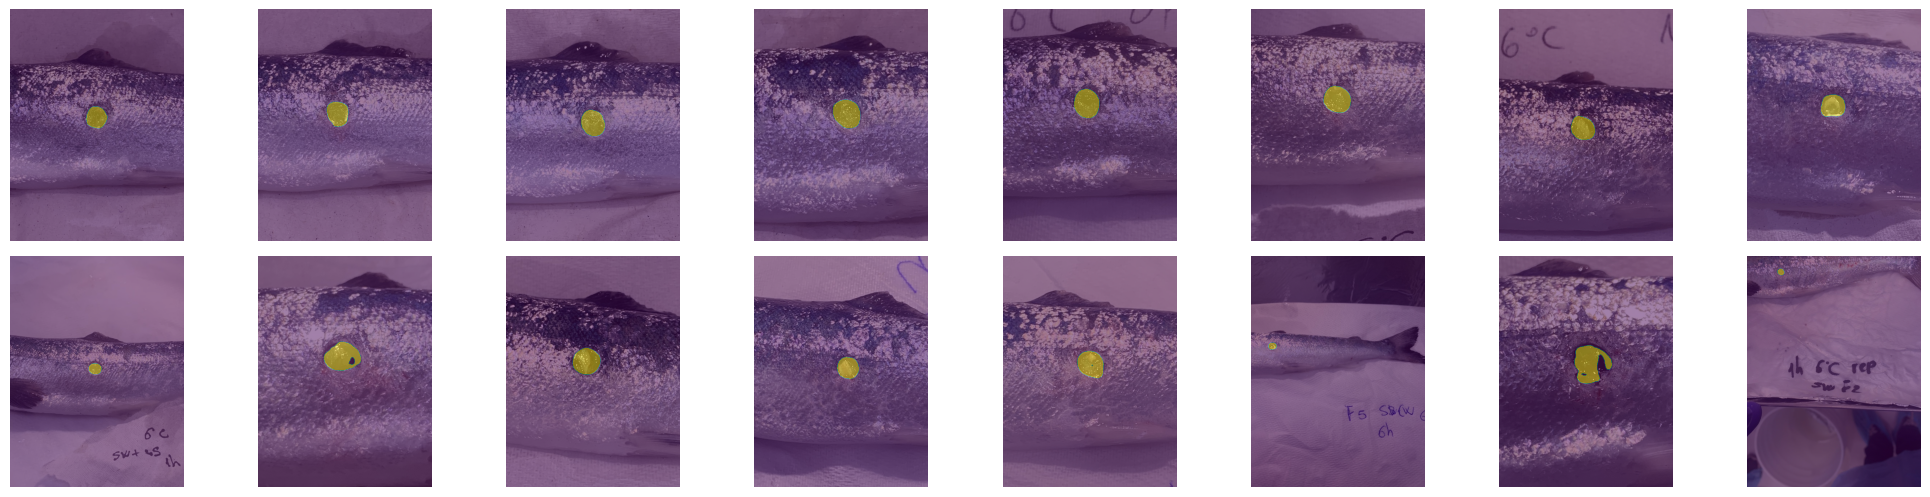

In [ ]:
imgs_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()

imgs_test = imgs_test.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_test, preds.unsqueeze(1))

In [ ]:
# Directorio para guardar las máscaras
output_dir = '/content/drive/MyDrive/Unet/predicted_masks_ordenadas/'
os.makedirs(output_dir, exist_ok=True)

# Itera sobre el DataLoader del conjunto de test
for i, imgs in enumerate(test_loader):
    imgs = imgs.to(device, dtype=torch.float32)
    with torch.no_grad():
        scores = model(imgs)
        preds = torch.argmax(scores, dim=1).float()

    # Mueve las predicciones a la CPU y guarda cada máscara
    preds = preds.cpu()
    batch_size = preds.size(0)  # Tamaño del batch actual
    for j in range(batch_size):
        mask = preds[j].squeeze().numpy() * 255  # Escalar de 0-1 a 0-255
        mask_img = Image.fromarray(mask.astype('uint8'))  # Convertir a imagen
        mask_img.save(os.path.join(output_dir, f'mask_{i * test_loader.batch_size + j}.png'))

print("Máscaras guardadas en", output_dir)


Máscaras guardadas en /content/drive/MyDrive/Unet/predicted_masks_ordenadas/
